Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

Defining a function that will display the quadatric weighted kappa cohen score, which will be our metric's evaluation metric. This function was provided by Aman Arora via an entry made on [Kaggle](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps). He also provides a great conceptual overview of the metric as well as an explanation of its mechanics. 

In [2]:
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

Reading in necessary data: the numpy arrays which represnt the retinal images, and a csv file with the corresponding diagnosis label value. 

In [3]:
train = pd.read_csv('./train.csv')
images = np.load('images.npy')

Defining our predictor variables (X) as our numerically represented images and the target variable (y) as the diagnosis label values.

In [4]:
X = images
y = train['diagnosis']

The normalized value counts of our target variable (diagnosis label value) will provide with our baseline score by taking the value of the majority class. If the dataset were perfectly balanced, each of the five classes would contain 20% of the data, but alas they do not. In this case, the 0 class (label value) accounts for 49.29% of our data and will therefore be considered the baseline accuracy score for our model. 

In [5]:
y.value_counts(normalize=True)

0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64

The data is then split into training and testing sets respectively. By default, the 75% of the data will be considered train data, and the remaining 25% will be considered testing data. Additionally, due to the imbalanced nature of our dataset, we will stratify our y variable.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [7]:
# X_train = X_train.astype('float32')/255
# X_test = X_test.astype('float32')/255

Using one-hot encoding our categorical target variable is transformed into a dummy array, so that it can be inputted into the neural network.

In [8]:
y_train = utils.to_categorical(y_train, 5)
y_test = utils.to_categorical(y_test, 5)

Double checking the shapes of the data before modeling. 

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2746, 128, 128, 3), (2746, 5), (916, 128, 128, 3), (916, 5))

In [10]:
# Simple Model with Early Stop

This model comes from the instruction at Generaly Assembly, as a part of their introduction to convolutional neural networks. It is comprised of two convolutional and two pooling layers – with standard kernel and pool sizes – repsectively, and a small number of image filters. After passing through a flattening layer, there are two hidden dense layers, using a five-node output layer for the corresponding five outcome classes. Relu activation functions are used throughout, with the exception of the output layer which uses softmax for multi-classifcation models such as these. 

The CNN is then compiled using categorical crossentropy as its loss function, Adam as an optimizer, and accuracy will be displayed as an additional evaluation metric.

Early stopping is instantiated as a callback, with changes in the validation loss over a five epoch period determining whether the network will continue or cease to run. 

The CNN model is then fit over the training data, with the testing data as validation, the model is set to run for 100 epochs, and our callback is set equivalent to the early stopping that was previously instantiated. 

In [11]:
cnn = Sequential()

cnn.add(Conv2D(filters = 6,       #number of filters to use
              kernel_size = (3, 3),   #dimensions of the filters
              activation = 'relu',    #activation function
              input_shape = (128, 128, 3)))  #shape of image

cnn.add(MaxPooling2D(pool_size = (2, 2)))   #filter dimensions
cnn.add(Conv2D(16, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(5, activation = 'softmax'))

cnn.compile(loss = 'categorical_crossentropy',
           optimizer = 'adam',
           metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

history = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 256,
                 epochs = 100,
                 verbose = 1,
                 callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 14s 1s/step - loss: 116.0971 - accuracy: 0.4108 - val_loss: 22.8762 - val_accuracy: 0.6419
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 16.7935 - accuracy: 0.5051 - val_loss: 8.9922 - val_accuracy: 0.6954
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 5.6286 - accuracy: 0.6639 - val_loss: 2.9714 - val_accuracy: 0.6517
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 1.8800 - accuracy: 0.6704 - val_loss: 1.7439 - val_accuracy: 0.6310
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 1.2639 - accuracy: 0.6908 - val_loss: 1.1708 - val_accuracy: 0.6921
Epoch 6/100
11/11 [==============================] - 12s 1s/step - loss: 0.9138 - accuracy: 0.7229 - val_loss: 1.0454 - val_accuracy: 0.6769
Epoch 7/100
11/11 [==============================] - 12s 1s/step - loss: 0.7780 - accuracy: 0.7495 - val_loss: 0.9683 - val_accuracy: 0.6769
Epoch 8/1

We create our target predictions based on the model fit on our test predictors. Both the actual target variable values and the predicted variable values are used to calculate the quadatric weighted kappa. 

In [12]:
y_preds = cnn.predict(X_test)
quadratic_weighted_kappa(np.argmax(y_test,axis=1), np.argmax(y_preds,axis=1))

0.6677412649829029

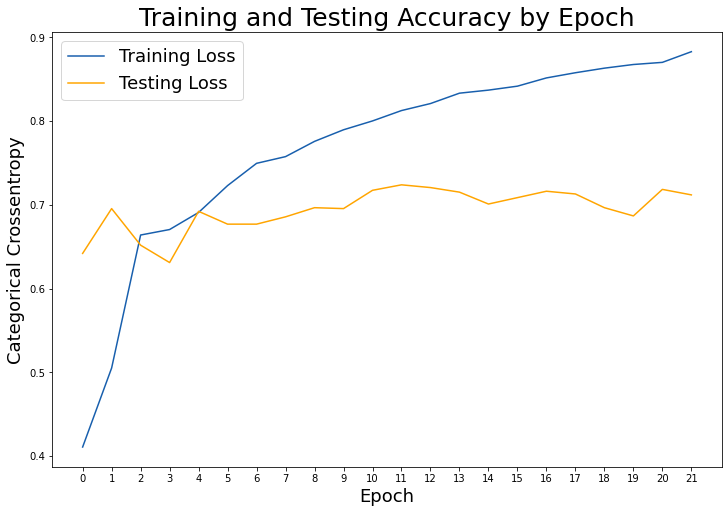

In [13]:
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(22), np.arange(22))

plt.legend(fontsize = 18);

This CNN structure was provided by James Le via an article he published on [Medium](https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d). He developed this CNN structure for a ten outcome image classification model that was intended to correctly identify which item of clothing an image depicted. The visual characteristics that help identify a range of diabetic retinopathy significance versus clothing items are inherently seperate; different signficances are associated with elements such as shape, line quality, contrast, as well as varying manifestations of noisey data within the images themselves. Despite these collective and composite truthes, as an experiment, we will test its performance in a completely different context. 

The sheer volume of its code leads one to believe it is a winning recipe. There are four convolutional layers, of which, pooling layers are placed after the second and fourth with the number of filters on each convolutional layer ranging from 32 to 128. The kernel size and pool size will remain within the standard range of values for these parameters. We are doubling the convolutional layers and, seperately, increasing the number of filters at exponential increments; indeed, we should already be expecting a significant difference in our outcomes one way or another.

Once we add our flattening layer, we add two hidden layers: the first with a wopping 512 nodes, and the second one with 128 nodes, which is narrowly wittled down to an output layer of five nodes for our corresponding class outcomes. 

Relu activation functions are used throughout, with the exception of the output layer which uses softmax for multi-classifcation models such as these. 

The CNN is then compiled using categorical crossentropy as its loss function, Adam as an optimizer, and accuracy will be displayed as an additional evaluation metric.

Early stopping is instantiated as a callback, with changes in the validation loss over a five epoch period determining whether the network will continue or cease to run. 

The CNN model is then fit over the training data, with the testing data as validation, the model is set to run for 100 epochs, and our callback is set equivalent to the early stopping that was previously instantiated. 

The changes we have made to model through adding layers and filters in the convolutional and pooling layers are further compounded by another exponentially incremental increase in nodes used in the hidden layers of our CNN. 

Additionally, outwardly, it's heavy use of various regularization methods make it attractive candidate to fix our previous model's overfit accuracy scores. On top of the early-stop callback regularization used in the first model, this CNN employs batch-normalzation at all convolutional layers as well as all hidden layers. Similarly, dropout regularization has been applied to the same layers, spare the input layer as there are no inputs to drop. Indeed, this is all promising, and perhaps, minimizing variance through regularization could simultaneously boost our currently underwhelming quadratic weighted kappa score of 0.66.

Hopefully, increasing the general complexity of the model by adding more filters, nodes, and layers can increase the predictive power and accuracy scores of our model while using a multi-facted regularization approach to attempt mitigating high variance and overfitness. 

In [14]:
cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (128, 128, 3)))   
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Flatten())

cnn4.add(Dense(512, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(5, activation='softmax'))

cnn4.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [15]:
history1 = cnn4.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 256,
                 epochs = 100,
                 verbose = 1,
                 callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 201s 18s/step - loss: 1.4099 - accuracy: 0.5605 - val_loss: 2.1189 - val_accuracy: 0.5240
Epoch 2/100
11/11 [==============================] - 252s 23s/step - loss: 1.0307 - accuracy: 0.6628 - val_loss: 1.8502 - val_accuracy: 0.4662
Epoch 3/100
11/11 [==============================] - 283s 26s/step - loss: 0.9232 - accuracy: 0.6868 - val_loss: 1.4382 - val_accuracy: 0.6386
Epoch 4/100
11/11 [==============================] - 259s 24s/step - loss: 0.8890 - accuracy: 0.6894 - val_loss: 1.0340 - val_accuracy: 0.6681
Epoch 5/100
11/11 [==============================] - 233s 21s/step - loss: 0.8663 - accuracy: 0.6992 - val_loss: 1.0946 - val_accuracy: 0.6441
Epoch 6/100
11/11 [==============================] - 219s 20s/step - loss: 0.8991 - accuracy: 0.6916 - val_loss: 1.5339 - val_accuracy: 0.5568
Epoch 7/100
11/11 [==============================] - 215s 20s/step - loss: 0.8033 - accuracy: 0.7087 - val_loss: 1.5436 - val_accuracy: 0.5437

In [16]:
y_preds2 = cnn4.predict(X_test)
quadratic_weighted_kappa(np.argmax(y_test,axis=1), np.argmax(y_preds2,axis=1))

0.5944763469381762

Alas, our second model failed us by all measurements: overall accuracy is down, variance is still high and discernible overfitness still present. Worst of all, the score for our prime evaluative metric (the quadtratic weighted kappa) has dropped even lower, providing little confidence in its overall efficacy. 

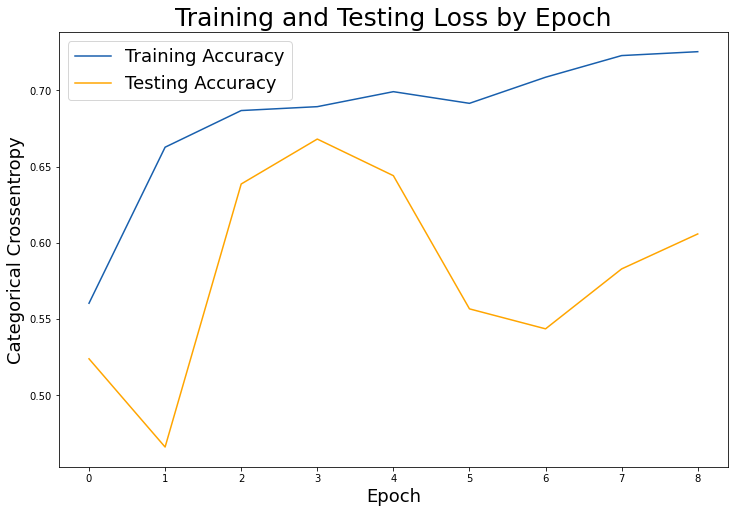

In [19]:
train_loss = history1.history['accuracy']
test_loss = history1.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(9), np.arange(9))

plt.legend(fontsize = 18);